In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
months = ['October', 'November', 'December', 'January', 'February', 'March', 'April']

In [3]:
acc = list()

In [4]:
f1 = list()

In [5]:
err = list()

In [6]:
house_data = pd.read_csv("../preprocessed_data/std_test_data_ebfd64742c95ab9f71f8ac8a810624464782d17d.csv")

In [7]:
house_data.head()

,index,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,HourofDay,Day,T_ctrl,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,T_out,RH_out
0,0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996
1,1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996
2,2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996
3,3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996
4,4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996


In [8]:
house_data.Month.value_counts()

5     8917
12    8889
1     8695
4     8611
11    8609
3     8233
6     7775
10    5859
2     5212
Name: Month, dtype: int64

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# October

In [10]:
working_df = house_data[house_data.Month == 10]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4682, 34) (4682, 21) (1171, 34) (1171, 21)


In [11]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 4682 samples, validate on 1171 samples
Epoch 1/20
4682/4682 [==============================] - 2s 491us/sample - loss: 0.6414 - accuracy: 0.9302 - val_loss: 0.2322 - val_accuracy: 0.9547
Epoch 2/20
4682/4682 [==============================] - 2s 365us/sample - loss: 0.2452 - accuracy: 0.9532 - val_loss: 0.1886 - val_accuracy: 0.9633
Epoch 3/20
4682/4682 [==============================] - 2s 367us/sample - loss: 0.2167 - accuracy: 0.9571 - val_loss: 0.1935 - val_accuracy: 0.9650
Epoch 4/20
4682/4682 [==============================] - 2s 363us/sample - loss: 0.2043 - accuracy: 0.9584 - val_loss: 0.1801 - val_accuracy: 0.9650
Epoch 5/20
4682/4682 [==============================] - 2s 398us/sample - loss: 0.1956 - accuracy: 0.9586 - val_loss: 0.1708 - val_accuracy: 0.9675
Epoch 6/20
4682/4682 [==============================] - 2s 425us/sample - loss: 0.1924 - accuracy: 0.9588 - val_loss: 0.1728 - val_accuracy: 0.9675
Epoch 7/20
4682/4682 [==============================] - 2s 363us

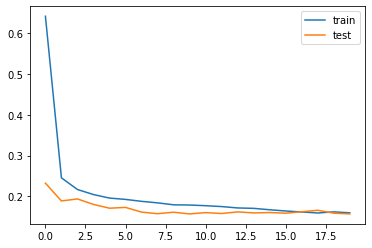

In [12]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

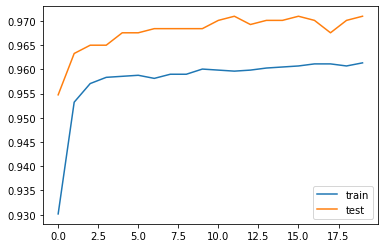

In [13]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [14]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

20325
18870
Error Percentage in predicted values is : 7.158671586715867 %


In [15]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9595882535477602

In [16]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [17]:
acc.append(max(history.history['accuracy']))

# November

In [18]:
working_df = house_data[house_data.Month == 11]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6882, 34) (6882, 21) (1721, 34) (1721, 21)


In [19]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6882 samples, validate on 1721 samples
Epoch 1/20
6882/6882 [==============================] - 3s 434us/sample - loss: 0.6417 - accuracy: 0.9087 - val_loss: 0.2847 - val_accuracy: 0.9489
Epoch 2/20
6882/6882 [==============================] - 3s 402us/sample - loss: 0.2928 - accuracy: 0.9425 - val_loss: 0.2446 - val_accuracy: 0.9512
Epoch 3/20
6882/6882 [==============================] - 3s 450us/sample - loss: 0.2732 - accuracy: 0.9426 - val_loss: 0.2382 - val_accuracy: 0.9529
Epoch 4/20
6882/6882 [==============================] - 3s 451us/sample - loss: 0.2655 - accuracy: 0.9438 - val_loss: 0.2220 - val_accuracy: 0.9535
Epoch 5/20
6882/6882 [==============================] - 4s 546us/sample - loss: 0.2567 - accuracy: 0.9452 - val_loss: 0.2480 - val_accuracy: 0.9465
Epoch 6/20
6882/6882 [==============================] - 3s 505us/sample - loss: 0.2530 - accuracy: 0.9448 - val_loss: 0.2178 - val_accuracy: 0.9541
Epoch 7/20
6882/6882 [==============================] - 3s 393us

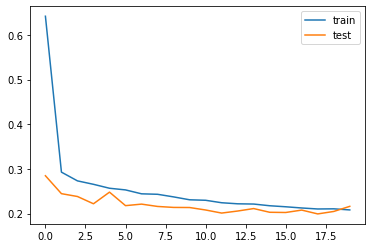

In [20]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

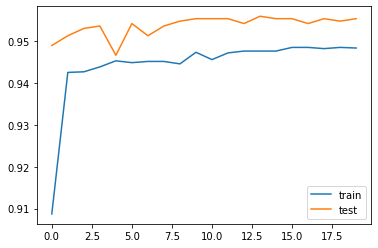

In [21]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [22]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

73485
75135
Error Percentage in predicted values is : 2.2453561951418655 %


In [23]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9366542315888838

In [24]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [25]:
acc.append(max(history.history['accuracy']))

# December

In [26]:
working_df = house_data[house_data.Month == 12]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(7106, 34) (7106, 21) (1777, 34) (1777, 21)


In [27]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 7106 samples, validate on 1777 samples
Epoch 1/20
7106/7106 [==============================] - 3s 429us/sample - loss: 0.7180 - accuracy: 0.8808 - val_loss: 0.3605 - val_accuracy: 0.9302
Epoch 2/20
7106/7106 [==============================] - 3s 368us/sample - loss: 0.3715 - accuracy: 0.9239 - val_loss: 0.3218 - val_accuracy: 0.9353
Epoch 3/20
7106/7106 [==============================] - 3s 368us/sample - loss: 0.3446 - accuracy: 0.9261 - val_loss: 0.3092 - val_accuracy: 0.9370
Epoch 4/20
7106/7106 [==============================] - 3s 370us/sample - loss: 0.3346 - accuracy: 0.9282 - val_loss: 0.3063 - val_accuracy: 0.9370
Epoch 5/20
7106/7106 [==============================] - 3s 371us/sample - loss: 0.3263 - accuracy: 0.9281 - val_loss: 0.2874 - val_accuracy: 0.9392
Epoch 6/20
7106/7106 [==============================] - 3s 369us/sample - loss: 0.3184 - accuracy: 0.9289 - val_loss: 0.3027 - val_accuracy: 0.9375
Epoch 7/20
7106/7106 [==============================] - 3s 369us

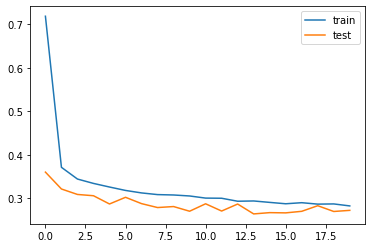

In [28]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

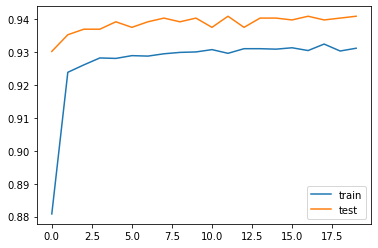

In [29]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [30]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

104850
98985
Error Percentage in predicted values is : 5.593705293276108 %


In [31]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9156436061799991

In [32]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [33]:
acc.append(max(history.history['accuracy']))

# January

In [34]:
working_df = house_data[house_data.Month == 1]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6951, 34) (6951, 21) (1738, 34) (1738, 21)


In [35]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6951 samples, validate on 1738 samples
Epoch 1/20
6951/6951 [==============================] - 3s 425us/sample - loss: 0.7017 - accuracy: 0.8957 - val_loss: 0.3899 - val_accuracy: 0.9264
Epoch 2/20
6951/6951 [==============================] - 3s 386us/sample - loss: 0.3607 - accuracy: 0.9335 - val_loss: 0.3262 - val_accuracy: 0.9367
Epoch 3/20
6951/6951 [==============================] - 3s 372us/sample - loss: 0.3326 - accuracy: 0.9380 - val_loss: 0.3402 - val_accuracy: 0.9379
Epoch 4/20
6951/6951 [==============================] - 3s 374us/sample - loss: 0.3189 - accuracy: 0.9393 - val_loss: 0.3030 - val_accuracy: 0.9396
Epoch 5/20
6951/6951 [==============================] - 3s 372us/sample - loss: 0.3080 - accuracy: 0.9396 - val_loss: 0.2992 - val_accuracy: 0.9390
Epoch 6/20
6951/6951 [==============================] - 3s 373us/sample - loss: 0.3024 - accuracy: 0.9406 - val_loss: 0.2959 - val_accuracy: 0.9407
Epoch 7/20
6951/6951 [==============================] - 3s 374us

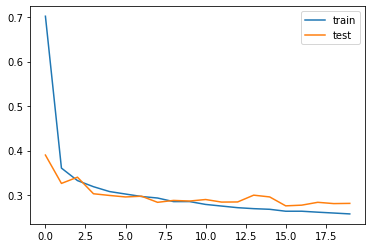

In [36]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

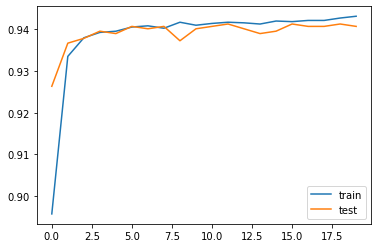

In [37]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [38]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

103050
98805
Error Percentage in predicted values is : 4.119359534206696 %


In [39]:
f1_score(y_test, y_predicted, average = 'weighted')

0.915270533778534

In [40]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [41]:
acc.append(max(history.history['accuracy']))

# February

In [42]:
working_df = house_data[house_data.Month == 2]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(4164, 34) (4164, 21) (1042, 34) (1042, 21)


In [43]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 4164 samples, validate on 1042 samples
Epoch 1/20
4164/4164 [==============================] - 2s 457us/sample - loss: 0.9046 - accuracy: 0.8605 - val_loss: 0.3980 - val_accuracy: 0.9309
Epoch 2/20
4164/4164 [==============================] - 2s 376us/sample - loss: 0.3873 - accuracy: 0.9272 - val_loss: 0.3380 - val_accuracy: 0.9395
Epoch 3/20
4164/4164 [==============================] - 2s 384us/sample - loss: 0.3446 - accuracy: 0.9313 - val_loss: 0.3190 - val_accuracy: 0.9395
Epoch 4/20
4164/4164 [==============================] - 2s 377us/sample - loss: 0.3263 - accuracy: 0.9349 - val_loss: 0.3112 - val_accuracy: 0.9415
Epoch 5/20
4164/4164 [==============================] - 2s 375us/sample - loss: 0.3179 - accuracy: 0.9364 - val_loss: 0.2999 - val_accuracy: 0.9376
Epoch 6/20
4164/4164 [==============================] - 2s 380us/sample - loss: 0.3119 - accuracy: 0.9337 - val_loss: 0.2941 - val_accuracy: 0.9395
Epoch 7/20
4164/4164 [==============================] - 2s 376us

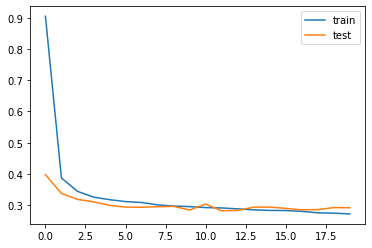

In [44]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

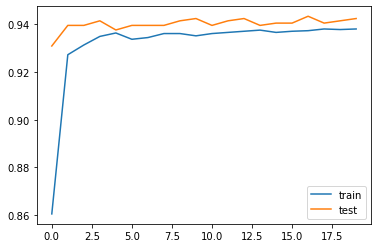

In [45]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [46]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

54330
53700
Error Percentage in predicted values is : 1.1595803423522915 %


In [47]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9191621792399444

In [48]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [49]:
acc.append(max(history.history['accuracy']))

# March

In [50]:
working_df = house_data[house_data.Month == 3]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6581, 34) (6581, 21) (1646, 34) (1646, 21)


In [51]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6581 samples, validate on 1646 samples
Epoch 1/20
6581/6581 [==============================] - 4s 543us/sample - loss: 0.6753 - accuracy: 0.9053 - val_loss: 0.3474 - val_accuracy: 0.9417
Epoch 2/20
6581/6581 [==============================] - 3s 469us/sample - loss: 0.3191 - accuracy: 0.9375 - val_loss: 0.3385 - val_accuracy: 0.9399
Epoch 3/20
6581/6581 [==============================] - 3s 499us/sample - loss: 0.2979 - accuracy: 0.9409 - val_loss: 0.3098 - val_accuracy: 0.9453
Epoch 4/20
6581/6581 [==============================] - 3s 489us/sample - loss: 0.2835 - accuracy: 0.9410 - val_loss: 0.3003 - val_accuracy: 0.9447
Epoch 5/20
6581/6581 [==============================] - 3s 444us/sample - loss: 0.2779 - accuracy: 0.9429 - val_loss: 0.2856 - val_accuracy: 0.9459
Epoch 6/20
6581/6581 [==============================] - 4s 540us/sample - loss: 0.2708 - accuracy: 0.9430 - val_loss: 0.2851 - val_accuracy: 0.9459
Epoch 7/20
6581/6581 [==============================] - 3s 431us

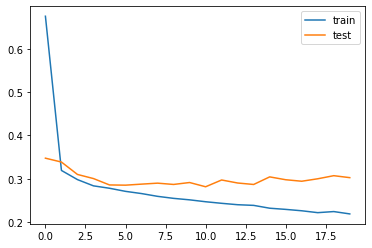

In [52]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

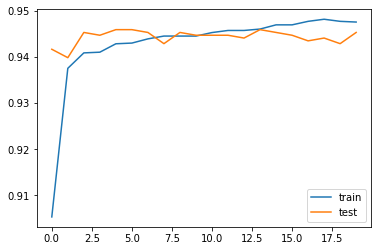

In [53]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [54]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

72780
68760
Error Percentage in predicted values is : 5.523495465787304 %


In [55]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9219516263216284

In [56]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [57]:
acc.append(max(history.history['accuracy']))

# April

In [58]:
working_df = house_data[house_data.Month == 4]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]

reframed = series_to_supervised(working_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6884, 34) (6884, 21) (1721, 34) (1721, 21)


In [59]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Train on 6884 samples, validate on 1721 samples
Epoch 1/20
6884/6884 [==============================] - 3s 438us/sample - loss: 0.7234 - accuracy: 0.8905 - val_loss: 0.4019 - val_accuracy: 0.9210
Epoch 2/20
6884/6884 [==============================] - 3s 375us/sample - loss: 0.3739 - accuracy: 0.9285 - val_loss: 0.3568 - val_accuracy: 0.9303
Epoch 3/20
6884/6884 [==============================] - 3s 372us/sample - loss: 0.3459 - accuracy: 0.9343 - val_loss: 0.3544 - val_accuracy: 0.9349
Epoch 4/20
6884/6884 [==============================] - 3s 377us/sample - loss: 0.3340 - accuracy: 0.9354 - val_loss: 0.3387 - val_accuracy: 0.9349
Epoch 5/20
6884/6884 [==============================] - 3s 375us/sample - loss: 0.3270 - accuracy: 0.9364 - val_loss: 0.3255 - val_accuracy: 0.9355
Epoch 6/20
6884/6884 [==============================] - 3s 376us/sample - loss: 0.3198 - accuracy: 0.9372 - val_loss: 0.3357 - val_accuracy: 0.9361
Epoch 7/20
6884/6884 [==============================] - 3s 372us

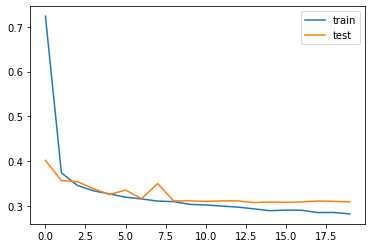

In [60]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

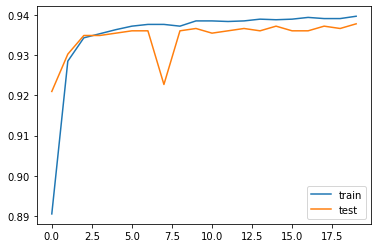

In [61]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [62]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

50505
45465
Error Percentage in predicted values is : 9.97920997920998 %


In [63]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9109266466090394

In [64]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [65]:
acc.append(max(history.history['accuracy']))

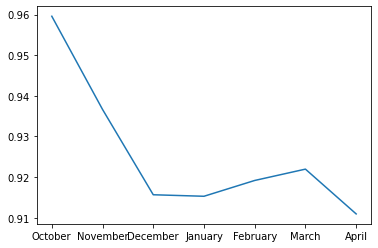

In [66]:
sns.lineplot(x = months, y = f1, sort = False)

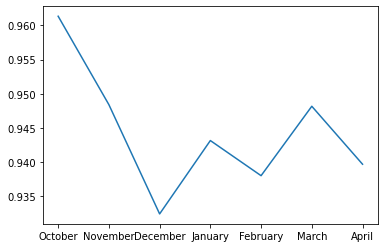

In [67]:
sns.lineplot(x = months, y = acc, sort = False)

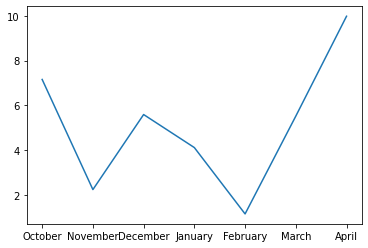

In [68]:
sns.lineplot(x = months, y = err, sort = False)